# Roberts Code (Transformer based)

## Imports

### MOAB!
[Mother of all BCI Benchmark!](https://github.com/NeuroTechX/moabb)

[Citation](https://iopscience.iop.org/article/10.1088/1741-2552/aadea0)

In [ ]:
!pip install download
!python -c "from download import download; download('https://raw.githubusercontent.com/NeuroTechX/moabb/master/requirements.txt', 'requirements.txt', replace=True)"
!pip install -r requirements.txt
!rm requirements.txt
!pip install -U https://github.com/NeuroTechX/moabb/archive/master.zip

from moabb.datasets import BNCI2014001
from moabb.paradigms import (LeftRightImagery, MotorImagery,
                             FilterBankMotorImagery)

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/download/download.py", line 208, in _fetch_file
    u = urllib.request.urlopen(req, timeout=timeout)
  File "/usr/lib/python3.7/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/usr/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/usr/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/usr/lib/python3.7/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/usr/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/usr/lib/python3.7/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found

During handling of the above exception, another exception occurred:

Traceback (most recent call last

### EEG brain code

[Github project](https://github.com/braindecode/braindecode)

[https://braindecode.org/index.html](documentation)

In [ ]:
!pip install braindecode
from braindecode.datasets.bbci import  BBCIDataset
from braindecode.datasets.moabb import MOABBDataset     #Braindecode stuff not sure if we will go this route 
import mne

### Other imports

In [ ]:
import os
import pdb
import argparse
import pickle as pkl

from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.autograd import Variable

from six.moves.urllib.request import urlretrieve
import tarfile
import pickle
import sys

## Datasets

### Pick a dataset

#### High Gamma Dataset
[Github Link to project](https://github.com/robintibor/high-gamma-dataset)

BELOW CODE DOESNT WORK NEED TO DO MANUALLY!!!!

In [ ]:
#!git clone https://gin.g-node.org/robintibor/high-gamma-dataset.git

In [ ]:
#!npx degit /robintibor/high-gamma-dataset -f

#### BCI2000
[data](https://physionet.org/content/eegmmidb/1.0.0/)

[paper: BCI2000: a general-purpose brain-computer interface (BCI) system](https://pubmed.ncbi.nlm.nih.gov/15188875/)

TOO BIG!

In [ ]:
#!wget -r -N -c -np https://physionet.org/files/eegmmidb/1.0.0/

#### BCIC IV 2a Dataset (Left, right, up, down based on left/right hand, foot and tongue)
[Description and citation](http://moabb.neurotechx.com/docs/generated/moabb.datasets.BNCI2014001.html?highlight=moabb%20paradigms)

[Article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3396284/)

Each run consits of :

![data format](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3396284/bin/fnins-06-00055-g016.jpg "Data format")

Since each run is 1001 samples at 250Hz (4 sec) long I assume we should remove the first second.

In [ ]:
#subject_id = 3
#dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[1])
#OR

dataset = BNCI2014001()

In [ ]:
dataset

### Play with data

In [ ]:
#dataset = BNCI2014001()
#data = BNCI2014001().get_data()

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


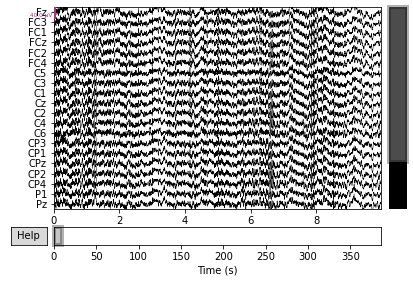

[0.00000e+00 4.00000e-03 8.00000e-03 ... 3.86928e+02 3.86932e+02
 3.86936e+02]


In [ ]:
#data[1]['session_E']['run_1'].plot()
#data, times = data[1]['session_E']['run_1'][:,:]
#print(times)

In [ ]:
#paradigm = MotorImagery(n_classes=4)
#print(paradigm.get_data.__doc__)
#X, y, metadata = paradigm.get_data(dataset=dataset)

In [ ]:
#print(X.shape)   #(trial, channel, time sample)
#print(y.shape)
#print(np.unique(y))
#code_dict = {'feet':0, 'left_hand':1, 'right_hand':2, 'tongue':3}
#print([code_dict[i] for i in list(y)])

## Utility Functions

### Options functions

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [ ]:
def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)

### Make Loader

In [ ]:
code_dict = {'feet':0, 'left_hand':1, 'right_hand':2, 'tongue':3}

def create_Loaders(data, paradigm, batchSize, windowSize):
  X, y, metadata = paradigm.get_data(dataset=data)

  repeats = int(750/windowSize)
  X, y, metadata = paradigm.get_data(dataset=dataset)

  y = np.array([code_dict[i] for i in list(y)])
  #y = np.eye(4)[y] #appearently crossEntropyLoss takes indices not one-hot
  y = np.repeat(y, repeats, axis=0)

  X = np.reshape(X[..., 250:1000], (repeats*X.shape[0], X.shape[1], windowSize))

  tensor_x = torch.tensor(X).float().to('cuda') # Remove first second since its only the cue
  tensor_y = torch.tensor(y).long().to('cuda')
  my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset

  train_size = int(X.shape[0]*0.6)
  val_size = int(X.shape[0]*0.2)
  test_size = X.shape[0] - train_size - val_size

  train, val, test = random_split(my_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

  train = DataLoader(train, batch_size=batchSize)
  val = DataLoader(val, batch_size=batchSize)
  test = DataLoader(test, batch_size=batchSize)

  return train, val, test

#### Tests

In [ ]:
'''
dataset = BNCI2014001()
paradigm = MotorImagery(n_classes=4)
train, val, test = create_Loaders(dataset,paradigm, 32, 50)
print(train)
'''

'\ndataset = BNCI2014001()\nparadigm = MotorImagery(n_classes=4)\ntrain, val, test = create_Loaders(dataset,paradigm, 32, 50)\nprint(train)\n'

In [ ]:
'''
for x, y in val:
  print(x.size())
  print(y.size())
'''

'\nfor x, y in val:\n  print(x.size())\n  print(y.size())\n'

### Compute Loss

In [36]:
def compute_loss(data, encoder, criterion, optimizer, opts):

    losses = []

    for X, y in data:
        outputs = encoder(X)
                    
        #print("out", outputs.size())
        #print("y", y.size())
        loss = criterion(outputs, y)
        #print("Batch loss: ", loss)
        losses.append(loss.item())
        
        ## training if an optimizer is provided
        if optimizer:
          # Zero gradients
          optimizer.zero_grad()
          # Compute gradients
          loss.backward()
          # Update the parameters of the encoder and decoder
          optimizer.step()
    print(outputs)
    print(y)

    return losses

### Training Loop

In [ ]:
def training_loop(train, val, encoder, criterion, optimizer, opts):

    #loss_log = open(os.path.join(opts.checkpoint_path, 'loss_log.txt'), 'w')

    best_val_loss = 1e6
    train_losses = []
    val_losses = []
    
    mean_train_losses = []
    mean_val_losses = []

    early_stopping_counter = 0
    
    for epoch in range(opts.nepochs):

        optimizer.param_groups[0]['lr'] *= opts.lr_decay
        
        train_loss = compute_loss(train, encoder, criterion, optimizer, opts)
        val_loss = compute_loss(val, encoder, criterion, None, opts)

        mean_train_loss = np.mean(train_loss)
        mean_val_loss = np.mean(val_loss)

        if mean_val_loss < best_val_loss:
            #checkpoint(encoder, decoder, idx_dict, opts)
            best_val_loss = mean_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter > opts.early_stopping_patience:
            print("Validation loss has not improved in {} epochs, stopping early".format(opts.early_stopping_patience))
            print("Obtained lowest validation loss of: {}".format(best_val_loss))
            return (train_losses, mean_val_losses)

        #gen_string = translate_sentence(TEST_SENTENCE, encoder, decoder, idx_dict, opts)
        print("Epoch: {:3d} | Train loss: {:.3f} | Val loss: {:.3f}".format(epoch, mean_train_loss, mean_val_loss))

        #loss_log.write('{} {} {}\n'.format(epoch, train_loss, val_loss))
        #loss_log.flush()

        train_losses += train_loss
        val_losses += val_loss

        mean_train_losses.append(mean_train_loss)
        mean_val_losses.append(mean_val_loss)

        #save_loss_plot(mean_train_losses, mean_val_losses, opts)

    print("Obtained lowest validation loss of: {}".format(best_val_loss))
    return (train_losses, mean_val_losses)

### Train Function

In [ ]:
def train(opts):
    encoder = Encoder(22, opts.hidden_size, opts.lstm_layers, opts.window_size) #22 for eeg channels

    if opts.cuda:
        encoder.cuda()
        print("Moved models to GPU!")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(encoder.parameters()), lr=opts.learning_rate)

    dataset = BNCI2014001()
    paradigm = MotorImagery(n_classes=4)
    train, val, test = create_Loaders(dataset,paradigm, opts.batch_size, opts.window_size)  

    try:
        losses = training_loop(train, val, encoder, 
                               criterion, optimizer, opts)
    except KeyboardInterrupt:
        print('Exiting early from training.')
        return encoder, losses
      
    return encoder, losses

## Feature Extraction

This is an appaling failure to make an LSTM autoencoder dont bother running it its not complete

**DO NOT RUN**

In [ ]:
class ScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The output must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        # FILL THIS IN
        # ------------
        q = self.Q(queries)
        batch_size = queries.size()[0]
        if (len(queries.size()) < 3):
          q = torch.unsqueeze(q, 1)
        k = self.K(keys)
        v = self.V(values)
        print("key size: ", k.size())
        print("q size: ", q.size())

        unnormalized_attention = torch.bmm(q, torch.transpose(k, 2, 1))* self.scaling_factor
        attention_weights = self.softmax(unnormalized_attention)
        print("att weight: ", attention_weights.size())
        context = torch.squeeze(torch.bmm(torch.transpose(attention_weights, 2, 1) , v)) #NOT masked
        
        return context, attention_weights

In [ ]:
class Encoder (nn.Module):

  def __init__(self, input_sizes, hidden_sizes, layersperlayer, kernel):

    super(Encoder, self).__init__()

    self.hidden_sizes = hidden_sizes
    self.input_sizes = input_sizes[:-1]
    self.output_sizes = input_sizes[1:]

    print([(i,h) for i, h in zip(input_sizes, hidden_sizes)])
    self.LSTMS = nn.ModuleList([nn.LSTM(input_size=i, hidden_size=h, num_layers=layersperlayer, batch_first=True) for i, h in zip(input_sizes, hidden_sizes)])
    self.attention_network = nn.ModuleList([ScaledDotAttention(h) for h in hidden_sizes])
    #self.linear = nn.ModuleList([nn.Linear(i, o) for i, o in zip(input_sizes, self.output_sizes)])
    self.conv = nn.ModuleList([nn.Conv1d(i, o, kernel) for i, o in zip(input_sizes, self.output_sizes)])

  def forward(self, input):
    batch_size, channel, seq_len = input.size()
    print(input.size())
    input = torch.reshape(input, (batch_size, seq_len, channel))
    hidden = torch.zeros(batch_size, self.hidden_sizes[0])#self.init_hidden(batch_size)
    cell = torch.zeros(batch_size, self.hidden_sizes[0])#self.init_hidden(batch_size)

    for i in range(len(self.hidden_sizes)):
      print(input.size())
      annotations, hidden = self.LSTMS[i](input) #, (hidden, cell))
      print("annotations: ", annotations.size())
      contexts, attention_weights = self.attention_network[i](annotations, annotations, annotations)
      print("context: ", contexts.size())
      input = self.linear[i](contexts)

  

  def init_hidden(self, bs):
        """Creates a tensor of zeros to represent the initial hidden states
        of a batch of sequences.

        Arguments:
            bs: The batch size for the initial hidden state.

        Returns:
            hidden: An initial hidden state of all zeros. (batch_size x hidden_size)
        """
        return to_var(torch.zeros(bs, self.hidden_size), self.opts.cuda)

In [ ]:
print(X.dtype)
data = torch.tensor(X[:32,...].astype(np.float64)).float()
#print(data)
crap = Encoder([22, 10], [20, 15], 2)
crap(data)

float64
[(22, 20), (10, 15)]
torch.Size([32, 22, 1001])
torch.Size([32, 1001, 22])
annotations:  torch.Size([32, 1001, 20])
key size:  torch.Size([32, 1001, 20])
q size:  torch.Size([32, 1001, 20])
att weight:  torch.Size([32, 1001, 1001])
context:  torch.Size([32, 1001, 20])


RuntimeError: ignored

In [ ]:
class Decoder (nn.Module):

  def __init__(self, input_size, hidden_sizes, num_layers):

    super(Decoder, self).__init__()

    self.hidden_sizes = hidden_sizes
    self.start_size = hidden_sizes[::-1][:-1]
    self.end_size = hidden_sizes[::-1][1:]

    self.LSTMS = nn.ModuleList([nn.LSTM(input_size=s, hidden_size=e, 1) for s, e in zip(self.start_size, self.end_size)])
    self.attention_network = nn.Sequential(
                                nn.Linear(hidden_size*2, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, 1)
                             )
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input):

    for i in range(len(heddensizes)):

In [ ]:
class AutoEncoder (nn.Module):

  def __init__(self, input_size, hidden_sizes, num_layers):

    super(AdditiveAttention, self).__init__()

    self.hidden_sizes = hidden_sizes
    self.start_size = hidden_sizes[:-1] + hidden_sizes[::-1][:-1]
    self.end_size = hidden_sizes[1:] + hidden_sizes[::-1][1:]

    self.LSTMS = nn.ModuleList([nn.LSTM(input_size=s, hidden_size=e, 1) for s, e in zip(self.start_size, self.end_size)])
    self.attention_network = nn.Sequential(
                                nn.Linear(hidden_size*2, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, 1)
                             )
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input):

    for i in range(len(heddensizes)):



## Model

### Embedding

my thought would be be to train conv1d autoencoder and using encoder as embedding

### Attention

In [ ]:
class ScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The output must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        # FILL THIS IN
        # ------------
        q = self.Q(queries)
        batch_size = queries.size()[0]
        if (len(queries.size()) < 3):
          q = torch.unsqueeze(q, 1)
        k = self.K(keys)
        v = self.V(values)
        #print("key size: ", k.size())
        #print("q size: ", q.size())

        unnormalized_attention = torch.bmm(q, torch.transpose(k, 1, 2))* self.scaling_factor
        attention_weights = self.softmax(unnormalized_attention)
        #print("att weight: ", attention_weights.size())
        context = torch.squeeze(torch.bmm(torch.transpose(attention_weights, 1, 2) , v)) #NOT masked
        
        return context, attention_weights

### Encoder

In [ ]:
class Encoder(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers, seq_len):

    super(Encoder, self).__init__()

    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.attention_network = ScaledDotAttention(hidden_size)
    self.linear = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Linear(hidden_size, hidden_size), nn.Linear(hidden_size, 4)) # 4 is num of classes change to use num_layers
    self.softmax = nn.Softmax(dim=1)
    
    self.positional_encodings = self.create_positional_encodings(max_seq_len=seq_len)

  def forward(self, input):
    batch_size, channel, seq_len = input.size()
    annotations, hidden = self.lstm(torch.reshape(input, (batch_size, seq_len, channel)))
    annotations = annotations + self.positional_encodings
    contexts, attention_weights = self.attention_network(annotations, annotations, annotations)
    output = self.linear(torch.squeeze(torch.sum(contexts, dim=1)))
    return  self.softmax(output)


  def create_positional_encodings(self, max_seq_len=1000):
    """Creates positional encodings for the inputs.
    Arguments:
        max_seq_len: a number larger than the maximum string length we expect to encounter during training
    Returns:
        pos_encodings: (max_seq_len, hidden_dim) Positional encodings for a sequence with length max_seq_len. 
    """
    pos_indices = torch.arange(max_seq_len)[..., None]
    dim_indices = torch.arange(self.hidden_size//2)[None, ...]
    exponents = (2*dim_indices).float()/(self.hidden_size)
    trig_args = pos_indices / (10000**exponents)
    sin_terms = torch.sin(trig_args)
    cos_terms = torch.cos(trig_args)
    pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
    pos_encodings[:, 0::2] = sin_terms
    pos_encodings[:, 1::2] = cos_terms
    pos_encodings = pos_encodings.cuda()
    #if self.opts.cuda:
    #    pos_encodings = pos_encodings.cuda()
    return pos_encodings


#### Verify model

In [ ]:
'''
print(X.dtype)
data = torch.tensor(X[:32,...]).float()
#print(data)
crap = Encoder(22, 50, 5, 1001)
A = crap(data)
print(A.size())
print(A)
'''

'\nprint(X.dtype)\ndata = torch.tensor(X[:32,...]).float()\n#print(data)\ncrap = Encoder(22, 50, 5, 1001)\nA = crap(data)\nprint(A.size())\nprint(A)\n'

In [ ]:
'''
fuck = X[..., :1000]
windowsize = 50
repeats = int(1000/50)
a = fuck.shape[0]
fuck = np.reshape(fuck, (repeats*a, fuck.shape[1], windowsize))
print(fuck.shape)
you = np.repeat(y, repeats, axis=0)
print(you.shape)
'''

'\nfuck = X[..., :1000]\nwindowsize = 50\nrepeats = int(1000/50)\na = fuck.shape[0]\nfuck = np.reshape(fuck, (repeats*a, fuck.shape[1], windowsize))\nprint(fuck.shape)\nyou = np.repeat(y, repeats, axis=0)\nprint(you.shape)\n'

In [ ]:
'''
crap = Encoder(22, 100, 5, windowsize)
A = crap(torch.tensor(fuck[:128,...]).float())
A[:5,...]
'''

'\ncrap = Encoder(22, 100, 5, windowsize)\nA = crap(torch.tensor(fuck[:128,...]).float())\nA[:5,...]\n'

## Train

In [ ]:
options = AttrDict()
dict_op = {
              'nepochs':20,
              'learning_rate':0.1,
              'lr_decay':0.99,
              'batch_size':64,
              'hidden_size':32,
              'input_size':22,
              'lstm_layers':5,
              'window_size':50,
              'cuda':True,
              'early_stopping_patience':5
}
options.update(dict_op)

#print_opts(options)
print(options)
model, loss = train(options)


Choosing from all possible events


{'nepochs': 20, 'learning_rate': 0.1, 'lr_decay': 0.99, 'batch_size': 64, 'hidden_size': 32, 'input_size': 22, 'lstm_layers': 5, 'window_size': 50, 'cuda': True, 'early_stopping_patience': 5}
Moved models to GPU!
